## Overlaid common sample over extinction map

In [1]:
import os, glob, getpass, sys
import warnings

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle

import itertools

from astropy.table import Table, join, vstack, hstack, Column, MaskedColumn, unique
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D

user = getpass.getuser()
sys.path.append('/Users/' + user + '/Dropbox/my_python_packages')
path = '../' 
sys.path.append(path)
from extra_codes import sample_comp    as samp_comp

In [2]:
# Path to data =================================
warnings.simplefilter('ignore', AstropyWarning)
path_control   = path + 'sample_control/OPH___control_sample.vot'
path_gaia      = path + 'sample_gaia/gaia_sample_cleaned.vot'
path_entire    = path + 'sample_comp/entire_sample_case_0.vot'
l1688          = SkyCoord('16h26m57s', '-24d31m00s', frame='icrs') # Extinction Peak (by-eye see cell #7)

# Read Data ====================================
sample_gaia    = Table.read(path_gaia,    format = 'votable')  ; sample_gaia.label    = 'Gaia'
sample_control = Table.read(path_control, format = 'votable')
sample_entire  = Table.read(path_entire,  format = 'votable')
sample_common  = sample_entire[sample_entire['DOH'] == 'YYY']

# Combine with Gaia Cat to get all cols ========
sample_control = join(sample_gaia, Table([sample_control['source_id']])) ; sample_control.label = 'Control'
sample_common  = join(sample_gaia, Table([sample_common['source_id']]))  ; sample_common.label  = 'Common'
sample_entire  = join(sample_gaia, Table([sample_entire['source_id']]))  ; sample_entire.label  = 'Combined'

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


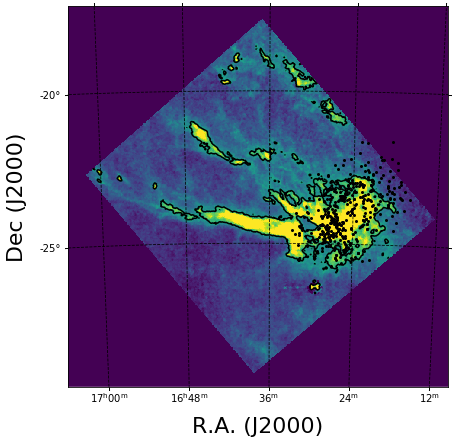

In [3]:
# Read Extinction Map ==========================
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:10904/10081&studyListingIndex=18_146394a15e2efcc6f22d801ac7ff
fits_path = path + '../extra_data/OphA_Extn2MASS_F_Eq.fits'
ext_map   = samp_comp.read_fits(fits_path)


# Make Plot ====================================
markersize = 5
ftsize     = 22

fig = plt.figure(figsize=[8,7])
ax  = fig.add_subplot(1,1,1, projection = ext_map['wcs'])

ax.set_xlabel("R.A. (J2000)", fontsize = ftsize)
ax.set_ylabel("Dec (J2000)",  fontsize = ftsize)

img_plot = ax.imshow(ext_map['data'], cmap='viridis', origin='lower', vmin = 0, vmax = 5)
ax.contour(ext_map['data'], cmap='Greys_r', alpha=1,lw=3, levels=[3])

ax.set_autoscale_on(False) # This to avoid to zoom out!
ax.plot(sample_common['ra'], sample_common['dec'], 'ko', markersize = 2, transform=ax.get_transform('fk5'))
ax.grid(color='black', alpha=0.95, linestyle='--')

plt.show()

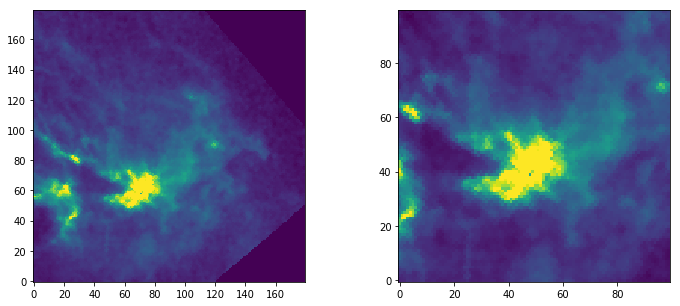

Savinf Fits file as:  ../../extra_data/OphA_Extn2MASS_F_Eq_trimmed.fits
Savinf Fits file as:  ../../extra_data/OphA_Extn2MASS_F_Eq_trimmed_zoom.fits


In [4]:
# Trim the image ===============================
position   = SkyCoord(246.25,-23.75, unit = u.deg, frame='icrs') # Common Region
position_z = SkyCoord(246.7,-24.3,   unit = u.deg, frame='icrs') # L1688 Zoom-in

cutout     = Cutout2D(ext_map['data'], position,   (180, 180), wcs=ext_map['wcs'])
cutout_z   = Cutout2D(ext_map['data'], position_z, (100, 100), wcs=ext_map['wcs'])


# Simple Plot ==================================
fig = plt.figure(figsize=[12,5])
plt.subplot(121)
plt.imshow(cutout.data,   origin='lower', vmax = 15)
plt.subplot(122)
plt.imshow(cutout_z.data, origin='lower', vmax = 15)
plt.show()

# Save it ======================================
nfits   = fits_path[0:fits_path.rfind('.fits')] + '_trimmed.fits'
nfits_z = fits_path[0:fits_path.rfind('.fits')] + '_trimmed_zoom.fits'
fits_nms = iter([nfits, nfits_z])

for inp in [cutout, cutout_z]:
    fname       = next(fits_nms)
    hdu         = fits.open(fits_path)
    hdu[0].data = inp.data
    hdu[0].header.update(inp.wcs.to_header()) # Update FITS header
    hdu.writeto(fname, overwrite=True)
    print(f'Savinf Fits file as:  {fname}')
    hdu.close()

In [5]:
#Distance Scale ==============================
pc2au      = (1 * u.parsec).to(u.astronomical_unit)
au2pc      = 1./pc2au.value
arcs2au    = 141 # Average distance to Oph [pc]: 1" = 141 AU >> 1' = 60 * 141 AU
len_30_min = 30 * 60 * arcs2au * au2pc

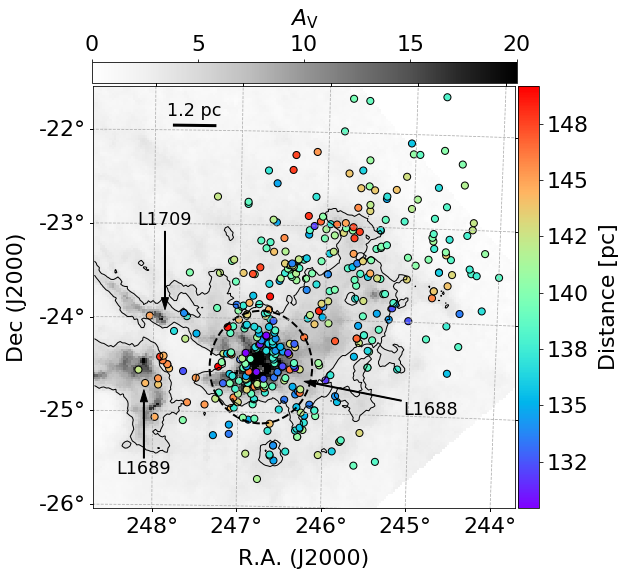

In [6]:
# Create Paper Plot ========================
# Color Bar tutorial: http://www.sc.eso.org/~bdias/pycoffee/codes/20160602/colorbar_demo.html
img        = samp_comp.read_fits(nfits)
figname    = '04_astrometry_extinction.pdf'
markersize = 5
ftsize     = 22
matplotlib.rcParams.update({'font.size': ftsize})  # << This to change AXIS fontsize - otherwise it does not work.




# Create grid to plot 2 color bars =========
gs = gridspec.GridSpec(3,3, height_ratios=[0.05,1,0.0], width_ratios=[0.0,1,0.05])
gs.update(left=0.10, right=0.62, bottom=0.08, top=0.97, wspace=0.01, hspace=0.02)


# Create Figure ============================
fig   = plt.figure(figsize=[12,7])
ax    = fig.add_subplot(gs[1,1], projection=img['wcs'])
lon   = ax.coords['dec']
lat   = ax.coords['ra']
lon.set_major_formatter('dd')
lat.set_major_formatter('dd')


# lon.ticklabels(pad = 0)
ax.set_xlabel("R.A. (J2000)", fontsize = ftsize)
ax.set_ylabel("Dec (J2000)",  fontsize = ftsize)

# Plot Extinction map ========
img_plot = ax.imshow(img['data'], cmap='Greys', origin='lower', vmin = 0, vmax = 20)
contour  = ax.contour(img['data'], cmap='Greys_r', alpha=1.0,linewidths=[1], levels=[4])

# Marc Lynds Clouds ==========
arrowprops = {'facecolor':'black', 'width':1.0, 'headwidth':7}
xycoords   = 'axes fraction'
ha         = 'center'
ax.annotate('L1709', xy=(0.17, 0.47), xytext=(0.17, 0.67), arrowprops=arrowprops, fontsize = ftsize*0.8, xycoords = xycoords, ha = ha)
ax.annotate('L1689', xy=(0.12, 0.28), xytext=(0.12, 0.08), arrowprops=arrowprops, fontsize = ftsize*0.8, xycoords = xycoords, ha = ha)
ax.annotate('L1688', xy=(0.5, 0.30),  xytext=(0.8, 0.22),  arrowprops=arrowprops, fontsize = ftsize*0.8, xycoords = xycoords, ha = ha)



# Plot Common Sample =========
# sub_samp = sample_common[sample_common['l1688_sep'] < 0.5] # Uncommon for sanity checks
sub_samp = sample_common
plt_1 = plt.scatter(sub_samp['ra'], sub_samp['dec'], c = sub_samp['distance'], cmap='rainbow', s = 50, marker = 'o',edgecolors = 'k',transform=ax.get_transform('icrs'))
plt.grid(linestyle = '--')

# Circle centred on Av peak ==
circle = Circle((l1688.ra.deg, l1688.dec.deg), radius=0.6, facecolor='none', edgecolor='k',linestyle='--', linewidth = 2, alpha = 1, transform=ax.get_transform('icrs'))
ax.add_patch(circle)


ax.set_autoscale_on(False)
ax.annotate(format(len_30_min, '3.1f') + ' pc',  xy=(0.0, 0.0), xytext=(0.24, 0.93), fontsize = ftsize*0.8, xycoords = xycoords, ha = ha)
ax.hlines(xmin=247.8, xmax=247.3, y=-21.95, transform=ax.get_transform('icrs'), linewidths= 3)


# Add Color bars =============
# Right =======
cbax = plt.subplot(gs[1,2]) # Place it where it should be.
cb   = plt.colorbar(cax = cbax, mappable = plt_1, orientation = 'vertical', ticklocation = 'right', format = '%.0f')
cb.set_label('Distance [pc]', labelpad=10)
# Top =========
cbax = plt.subplot(gs[0,1]) # Place it where it should be.
cb = plt.colorbar(cax = cbax, mappable = img_plot, orientation = 'horizontal', ticklocation = 'top', format = '%.0f')
cb.set_label(r'$A_\mathrm{V}$', labelpad=10)


plt.show()
fig.savefig(figname, bbox_inches = 'tight', overwrite = True)

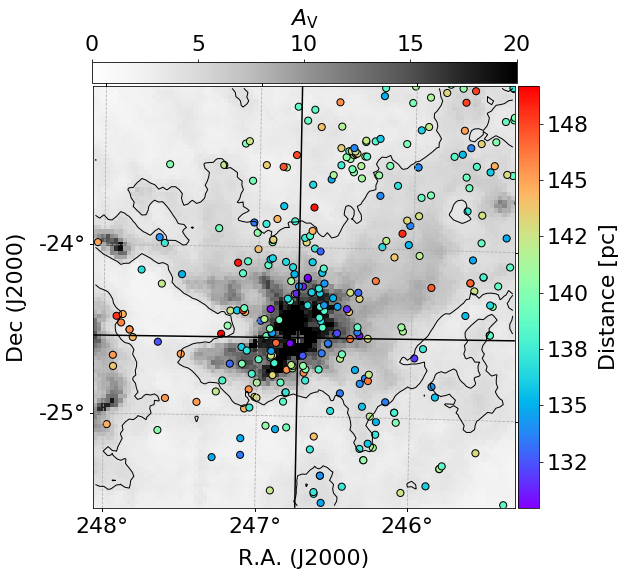

Extinction Peak at 246.74, -24.52


In [7]:
# Create Paper Plot (ZOOM-IN) ==============
img        = samp_comp.read_fits(nfits_z)
figname    = '04_astrometry_extinction_zoom.pdf'
markersize = 5
ftsize     = 22
matplotlib.rcParams.update({'font.size': ftsize})  # << This to change AXIS fontsize - otherwise it does not work.


# Create grid to plot 2 color bars =========
gs = gridspec.GridSpec(3,3, height_ratios=[0.05,1,0.0], width_ratios=[0.0,1,0.05])
gs.update(left=0.10, right=0.62, bottom=0.08, top=0.97, wspace=0.01, hspace=0.02)


# Create Figure ============================
fig   = plt.figure(figsize=[12,7])
ax    = fig.add_subplot(gs[1,1], projection=img['wcs'])
lon   = ax.coords['dec']
lat   = ax.coords['ra']
lon.set_major_formatter('dd')
lat.set_major_formatter('dd')
ax.set_xlabel("R.A. (J2000)", fontsize = ftsize)
ax.set_ylabel("Dec (J2000)",  fontsize = ftsize)

# Plot Extinction map ========
img_plot = ax.imshow(img['data'], cmap='Greys', origin='lower', vmin = 0, vmax = 20)
contour  = ax.contour(img['data'], cmap='Greys_r', alpha=1.0,linewidths=[1], levels=[4])


# Plot Common Sample =========
ax.set_autoscale_on(False) # This to avoid to zoom out!
plt_1 = plt.scatter(sample_common['ra'], sample_common['dec'], c = sample_common['distance'], cmap='rainbow', s = 50, marker = 'o',edgecolors = 'k',transform=ax.get_transform('icrs'))
plt.grid(linestyle = '--')

# Mark highest extinction point
ax.hlines(xmin=250, xmax=245, y=l1688.dec.deg, transform=ax.get_transform('icrs'))
ax.vlines(ymin=-30, ymax=-22, x=l1688.ra.deg, transform=ax.get_transform('icrs'))


# Add Color bars =============
# Right =======
cbax = plt.subplot(gs[1,2]) # Place it where it should be.
cb   = plt.colorbar(cax = cbax, mappable = plt_1, orientation = 'vertical', ticklocation = 'right', format = '%.0f')
cb.set_label('Distance [pc]', labelpad=10)
# Top =========
cbax = plt.subplot(gs[0,1]) # Place it where it should be.
cb = plt.colorbar(cax = cbax, mappable = img_plot, orientation = 'horizontal', ticklocation = 'top', format = '%.0f')
cb.set_label(r'$A_\mathrm{V}$', labelpad=10)


plt.show()
fig.savefig(figname, bbox_inches = 'tight', overwrite = True)

print(f'Extinction Peak at {l1688.ra.deg:5.2f}, {l1688.dec.deg:5.2f}')